# keras embedding을 이용한 문서 분류

딥러닝 기법을 사용하여 문서 분류를 해보려 한다.

## 데이터

### 데이터 불러오기

In [1]:
import nltk
from nltk.corpus import movie_reviews

nltk.download('movie_reviews')
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/cho2jiwoo/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


### 데이터 전처리

텍스트 데이터를 분석에 사용할 수 있는 형태로 변환시켜준다. 

여기선 `Keras`를 사용해 텍스트를 토큰화 시킨 후 시퀀스 데이터로 변환시켜 줄것이다.

<img src="https://codetorial.net/tensorflow/_images/natural_language_processing_in_tensorflow_02.png" width="40%" height="40%"/>

출처: https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html

In [2]:
from keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

num of tokens: 43296


다음으로 토큰화한 단어들을 행렬을 만들어준다. `mode='binary'`는 단어가 있으면 1 없으면 0을 부여해준다.

In [3]:
bow = tokenizer.texts_to_matrix(reviews, mode='binary')
bow

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [4]:
bow.shape

(2000, 10000)

서로 다른 갯수의 단어로 이루어진 문장을 같은 길이로 만들어주기 위해 패딩을 사용한다. `Keras`에서 제공하는 `pad_sequences` 함수를 사용하면 된다.

부족한 길이의 시쿼스는 0으로 채워 같은 길이의 시퀀스로 만들어 준다.

<img src="https://codetorial.net/tensorflow/_images/natural_language_processing_in_tensorflow_03.png" width="40%" height="40%"/>

출처: https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html

In [5]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  38    1  328   52   20  769   52   20   52   20    2    4  910  114
   52   20 5277    4 1386  171    8  632    3   63    4    9    6  321
   25 1957  143   18 2926  120  301  254    5 9489    2   15  150  143
    3  102   16   44   35    9   91    6  256  103    1  164 2851  100
    3  100  208   18   72  259    4 4077   42   82    2   94   45    6
   14  247  954  353   37  613  294   14  133  801    5 3146   16    9
  138    5  257    5 3146    9  308  313   64  369  493  226    3   75
   36   86  171  439 2795   46   56 1747    7    1 5675   25   92    1
 1280  204    6    8    1 4078    3   18  158 5676   19 1711   38   14
   39   62  175 4079   63    4    9   40   21    1  268   84  212   39
   35    4    1   82    8  197  442    5   86    2   98  251    4  261
   16    9  137  248    1   86    1   15   35    8   43  439   18  618
    1 1486  311   11  121   38   14    6    8   34  167  245   86  276
    8    1  161    6   55    9   56  141   36   20  284    1  801    5
 2016 

이제 목표 변수를 준비해준다.

In [6]:
label_dict = {'pos':0, 'neg':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### train set과 test set으로 나누기

train set과 test set을 8:2로 나누었다.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


목표변수가 넘파이 배열이어야 하기 때문에 리스트에서 넘파이 배열로 캐스팅 시켜주었다.

In [8]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

## 딥러닝 

### 모델 구축

간단한 인공 신경망 모델을 구축해보자. 

- `model = Sequential()`: Squential 모델을 만들고, 레이어를 추가

- `model.add(Embedding(max_words, 32, input_length=maxlen))`: 임베딩 레이어(embedding layer)를 추가
    - 케라스는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 한번 더 바꾸고나서 임베딩 층의 입력으로 사용하는 것이 아니라, 단어를 정수 인덱스로만 바꾼채로 임베딩 층의 입력으로 사용해도 룩업 테이블 된 결과인 임베딩 벡터를 리턴한다.

- `model.add(Flatten())`: 행렬을 1차원 배열로 변환

- `model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])`: 
    - **옵티마이저(optimizer)**: 손실 함수를 기반으로 네트워크가 어떻게 업데이트될지 결정.
    - **RMSProp**: 아다그라드의 보폭 민감도를 보완한 방법
    - **손실 함수(loss function)**: 머신러닝 혹은 딥러닝 모델의 출력값과 사용자가 원하는 출력값의 오차
    - **binary_crossentropy**: y값이 (ex. 0,1) 인 이진 분류기를 훈련할 때 자주 사용되는 손실 함수 (multi-label classification)
    

- `model.add(Dense(1, activation='sigmoid'))`: 출력층에서 activation function으로 시그모이드 함수를 사용


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

2021-11-07 21:59:56.184702: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 1s 51ms/step - loss: 0.6934 - acc: 0.5094 - val_loss: 0.6909 - val_acc: 0.5156
Epoch 2/30
5/5 [==============================] - 0s 15ms/step - loss: 0.6385 - acc: 0.8672 - val_loss: 0.6893 - val_acc: 0.5344
Epoch 3/30
5/5 [==============================] - 0s 24m

loss 함수를 그래프로 그려보자.

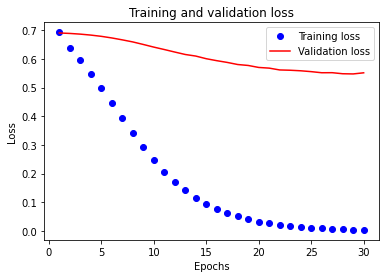

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

epoch 횟수가 늘어남에 따라 loss가 줄어드는것을 알 수 있다.

### 모델 평가

In [11]:
score = model.evaluate(X_test, y_test)
print(score)

13/13 [==============================] - 0s 1ms/step - loss: 0.5182 - acc: 0.7525
[0.5181632041931152, 0.7524999976158142]


test set에서 모델의 성능으로 loss는 약 0.53, accuracy는 약 0.74가 나왔다.

### RNN/LSTM

**순환 신경망(Recurrent neural network, RNN)** 은 인공 신경망의 한 종류로, 유닛간의 연결이 순환적 구조를 갖는 특징을 갖고 있다. 이러한 구조는 시변적 동적 특징을 모델링 할 수 있도록 신경망 내부에 상태를 저장할 수 있게 해주므로, 순방향 신경망과 달리 내부의 메모리를 이용해 시퀀스 형태의 입력을 처리할 수 있다.

**LSTM (Long Short Term Memory)** 는 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조를 말합니다. 주로 시계열 처리나, 자연어 처리에 사용됩니다.

In [12]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
5/5 [==============================] - 4s 537ms/step - loss: 0.6930 - acc: 0.4969 - val_loss: 0.6925 - val_acc: 0.5656
Epoch 2/30
5/5 [==============================] - 1s 307ms/step - loss: 0.6878 - acc: 0.7281 - val_loss: 0.6909 - val_acc: 0.5781
Epoch 3/30
5/5 [==============================] - 2s 523ms/step - loss: 0.6771 - acc: 0.7859 - val_loss: 0.6866 - val_acc: 0.5938
Epoch 4/30
5/5 [==============================] - 2s 498ms/step - loss: 0.6437 - acc: 0.8070 - val_loss: 0.7307 - val_acc: 0.5188
Epoch 5/30
5/5 [==============================] - 3s 563ms/step - loss: 0.6102 - acc: 0.8148 - val_loss: 0.6609 - val_acc: 0.6469
Epoch 6/30
5/5 [==============================] - 3s 391ms/step - loss: 0.5573 - acc: 0.8992 - val_loss: 0.6385 - val_acc: 0.6500
Epoch 7/30
5/5 [==============================] - 2s 472ms/step - loss: 0.4728 - acc: 0.8883 - val_loss: 0.7200 - val_acc: 0.6125
Epoch 8/30
5/5 [==============================] - 2s 346ms/step - loss: 0.4779 - acc: 0.85

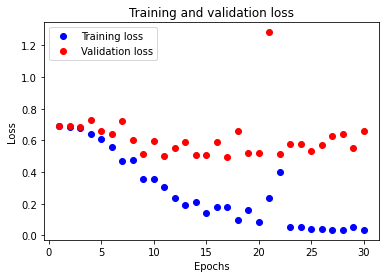

In [14]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

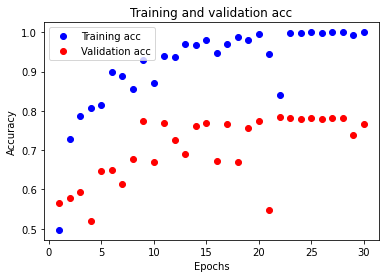

In [15]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

epoch 횟수가 늘어나면서 train set의 loss는 줄어들고 accuracy는 증가하는것으로 나타나는데 test set은 train set만큼의 loss 감소나 accuracy 증가가 이뤄지지 않는듯 보인다.

In [16]:
score = model.evaluate(X_test, y_test)
print(score)

13/13 [==============================] - 0s 29ms/step - loss: 0.5915 - acc: 0.7875
[0.5915176272392273, 0.7875000238418579]


test set에서 모델의 성능으로 loss는 약 0.55, accuracy는 약 0.78이 나왔다.

이는 train set의 데이터가 충분치 않아서 발생하는것으로 보여 pre-trained 임베딩을 사용해서 모델을 구축해보자.

### pre-trained embedding 사용

[GloVe](https://nlp.stanford.edu/projects/glove/)는 Global Vectors for Word Representation의 약자로 pre-trained 된 워드 임베딩이다.

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [17]:
glove_dir = './datasets/'
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Num of word vectors:', len(embeddings_index))

Num of word vectors: 400001


처음 데이터를 생성할 때 사용한 tokenizer에서 word_index를 추출해주고, 이 word_index에 맞게 glove로부터 해당하는 word vector를 가져온다

In [18]:
word_index = tokenizer.word_index
len(word_index)

43296

In [19]:
#embedding matrix를 생성: word_index에서 max_words 만큼의 단어에 대해 glove의 embeddings_index를 추출하여 matrix 생성
#추출한 matrix는 embedding 층의 weight로 고정해서 사용함

embedding_dim = 100 # glove의 vector dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #값을 고정
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


TesorFlow 2.0 부터 `keras`가 `TensorFlow`의 high-level API로 공식 도입 되면서 필요한 모듈을 임포트할 때 이전 방법들과 전부 호환되진 않는것 같다.

`tf.keras.optimizers.Adam`을 사용하려면 `tensorflow`에서 `keras` 모듈을 불러와야 *AttributeError: module 'keras.optimizers' has no attribute 'Adam'* 에러가 안난다.

In [42]:
from tensorflow import keras

#rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0) #default lr은 0.001
#rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001
adam = keras.optimizers.Adam(learning_rate=0.005) #default lr은 0.001. UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.

# pre-train이 되어 있으므로 적은 수의 test set으로도 학습이 가능
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 
#model.save_weights('pre_trained_glove_model.h5')

Epoch 1/30
5/5 [==============================] - 6s 656ms/step - loss: 0.0677 - acc: 1.0000 - val_loss: 0.9747 - val_acc: 0.6719
Epoch 2/30
5/5 [==============================] - 2s 396ms/step - loss: 0.0679 - acc: 1.0000 - val_loss: 0.9099 - val_acc: 0.6656
Epoch 3/30
5/5 [==============================] - 2s 321ms/step - loss: 0.0683 - acc: 1.0000 - val_loss: 0.9110 - val_acc: 0.6656
Epoch 4/30
5/5 [==============================] - 2s 303ms/step - loss: 0.0678 - acc: 1.0000 - val_loss: 0.9513 - val_acc: 0.6719
Epoch 5/30
5/5 [==============================] - 2s 347ms/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.9659 - val_acc: 0.6906
Epoch 6/30
5/5 [==============================] - 2s 527ms/step - loss: 0.0675 - acc: 1.0000 - val_loss: 0.9663 - val_acc: 0.6969
Epoch 7/30
5/5 [==============================] - 2s 366ms/step - loss: 0.0675 - acc: 1.0000 - val_loss: 0.9809 - val_acc: 0.6906
Epoch 8/30
5/5 [==============================] - 1s 280ms/step - loss: 0.0674 - acc: 1.00

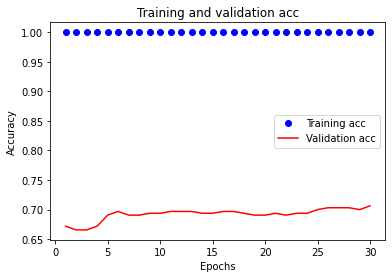

In [43]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
score = model.evaluate(X_test, y_test)
print(score)

13/13 [==============================] - 0s 31ms/step - loss: 0.9416 - acc: 0.7100
[0.9415997266769409, 0.7099999785423279]


예제로 주어진 파라미터로는 성능이 매우 좋지 않게 나왔다. 넉넉한 메모리 환경에서 시간을 충분히 두고 batch size를 줄이거나 epoch를 조절하면 성능을 높일 수 있을 것 같다.

### glove를 사용하지 않으면서 좀 더 정교한 모형을 사용하여 학습

`kernel_regularizer` 파라미터에 l2 norm을 적용하였다. 가중치 행렬의 모든 원소를 제곱하고 0.1을 곱하여 네트워크의 전체 손실에 더해진다는 의미이다.

In [28]:
from keras.layers import SimpleRNN, LSTM
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
#model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))) #0.01을 먼저 시도했음

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow import keras

#adam = optimizers.Adam(lr=0.005) #default lr은 0.001
rmsprop = keras.optimizers.RMSprop(learning_rate=0.005) #default lr은 0.001

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc']) 
#lr 조절 없고 l2=0.01일 때 test 0.775 나옴

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 

Epoch 1/30
5/5 [==============================] - 4s 527ms/step - loss: 0.8229 - acc: 0.5250 - val_loss: 0.7882 - val_acc: 0.5406
Epoch 2/30
5/5 [==============================] - 2s 297ms/step - loss: 0.8318 - acc: 0.5953 - val_loss: 0.7623 - val_acc: 0.5688
Epoch 3/30
5/5 [==============================] - 2s 386ms/step - loss: 0.6494 - acc: 0.7930 - val_loss: 0.7502 - val_acc: 0.5594
Epoch 4/30
5/5 [==============================] - 2s 389ms/step - loss: 0.5483 - acc: 0.8562 - val_loss: 0.6806 - val_acc: 0.6875
Epoch 5/30
5/5 [==============================] - 2s 368ms/step - loss: 0.4345 - acc: 0.9055 - val_loss: 0.6587 - val_acc: 0.7188
Epoch 6/30
5/5 [==============================] - 2s 532ms/step - loss: 0.3678 - acc: 0.9305 - val_loss: 0.7198 - val_acc: 0.6500
Epoch 7/30
5/5 [==============================] - 2s 365ms/step - loss: 0.3017 - acc: 0.9656 - val_loss: 0.7266 - val_acc: 0.6594
Epoch 8/30
5/5 [==============================] - 3s 594ms/step - loss: 0.2793 - acc: 0.96

In [31]:
score = model.evaluate(X_test, y_test)
print(score)

13/13 [==============================] - 0s 30ms/step - loss: 0.8243 - acc: 0.6875
[0.824343740940094, 0.6875]


이 모델도 마찬가지로 성능이 좋지 못하다.

## Reference

- https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html
- https://ko.wikipedia.org/wiki/순환_신경망
- http://www.incodom.kr/LSTM
- https://wdprogrammer.tistory.com/33
- https://wikidocs.net/33793
- https://thebook.io/006975/part01/ch03/01/03/
- https://knowledgeforengineers.tistory.com/124
- https://didu-story.tistory.com/27